# InventarioFlorestal

> A seguir será apresentada a documentação e exemplo de uso da classe `InventarioFlorestal`

In [ ]:
#| default_exp InventarioFlorestal

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
class InventarioFlorestal:
    
    'Cálculo das estatitísticas de inventário amostragem casual simples e extratificada'
    
    def __tratativa_tabelas(dados, parcela, dap, ht, estrato = None,
                     id_arvore = None, volume = None, equacao_volume = None):

        dicionario = {'renomear_colunas':{estrato : 'estrato',parcela: 'parcela', id_arvore: 'n_arvores',
                                             dap: 'dap', ht : 'ht'},
                     'colunas_agrupar': {'ACS':'parcela','AE':['estrato','parcela']},
                     'metodo_agregacao':{'com_arvore':{'volume': np.sum,'gi': np.sum,'n_arvores': lambda x: len(set(x))},
                                         'sem_arvore':{'volume': np.sum,'gi': np.sum,'dap': lambda x: len(x)}}}
        
        # verificacoes iniciais
        if (equacao_volume is not None) and (isinstance(equacao_volume, types.FunctionType) == False):
            
            raise TypeError("O parâmetro 'equacao_volume' deve ser uma função.")
        
        # salvando dataframe apenas com colunas que serão usadas
        colunas = [estrato,parcela,id_arvore,dap,ht]

        dados_tratado = dados[[x for x in colunas if x is not None]].copy()

        # renomeando as colunas do dataframe
        dados_tratado.rename(columns = dicionario['renomear_colunas'], inplace=True)

        # criando coluna com área basal
        dados_tratado['gi'] = (dados_tratado['dap']**2*np.pi)/40000

        # verificando se há coluna de volume
        if volume is None:

            dados_tratado['volume'] = equacao_volume(dados_tratado)

        else:
            
            dados_tratado['volume'] = dados[volume].copy()

        # salvando colunas que serão agrupadas e dicionário com metódo de agregação
        col_agrupar = dicionario['colunas_agrupar']['ACS'] if estrato is None else dicionario['colunas_agrupar']['AE']
        metodo_agregacao = dicionario['metodo_agregacao']['sem_arvore'] if id_arvore is None else dicionario['metodo_agregacao']['com_arvore']

        # criando tabela dinamica por parcela, soma de volume, soma de área basal e número de árvores
        dados_pivotado = pd.DataFrame(dados_tratado.pivot_table(index=col_agrupar,aggfunc = metodo_agregacao))
        dados_pivotado.reset_index(inplace = True)
        dados_pivotado.rename(columns = {'dap': 'n_arvores'}, inplace = True)

        return {'tabela_dados': dados_tratado, 'tabela_parcelas': dados_pivotado}

    def __estatisticas(self):
        
        if 'estrato' in self.tabela_dados.columns:
            
            # Calculando número de estratos
            n_estratos = len(self.tabela_parcelas['estrato'].unique())
            
            if n_estratos != len(self.__area_estratos):
                
                raise SyntaxError("O número de estratos no parâmetro area_estratos é diferente do número de estratos na tabela.")

            area_total = sum([self.__area_estratos[k] for k in self.__area_estratos])

            calc_estrato = {str(k): {} for k in self.__area_estratos}

            for k, v in self.__area_estratos.items():
                
                calc_estrato[str(k)]['area'] = v
                calc_estrato[str(k)]['Wh'] = v/area_total
                calc_estrato[str(k)]['Nh'] = (v*10000)/self.__area_parcela
                calc_estrato[str(k)]['nh'] = len(self.tabela_parcelas['estrato'][self.tabela_parcelas['estrato'].astype(str) == str(k)])
                calc_estrato[str(k)]['Xh'] = np.mean(self.tabela_parcelas['volume'][self.tabela_parcelas['estrato'].astype(str) == str(k)])
                calc_estrato[str(k)]['sh'] = np.std(self.tabela_parcelas['volume'][self.tabela_parcelas['estrato'].astype(str) == str(k)],ddof = 1)**2
            
            Wh = np.array([calc_estrato[x]['Wh'] for x in calc_estrato.keys()])
            Nh = np.array([calc_estrato[x]['Nh'] for x in calc_estrato.keys()])
            nh = np.array([calc_estrato[x]['nh'] for x in calc_estrato.keys()])
            Xh = np.array([calc_estrato[x]['Xh'] for x in calc_estrato.keys()])
            sh = np.array([calc_estrato[x]['sh'] for x in calc_estrato.keys()])
                
            # calculando intensidade amostral
            ia = (self.__area_parcela*sum(nh))/(area_total*10000)*100

            # calculando média estratificada
            media_estratificada =  sum(np.array(Wh)*np.array(Xh))

            # calculando média da variancia estratificada

            # população finita
            if ia >= 2:
                sy_estratificada = sum(((Wh**2*sh)/nh)*(1-(nh/Nh)))
    
            # população infinita
            else:
                sy_estratificada = sum((Wh**2*sh)/nh)
                        
            # calculando valor T
            t = scipy.stats.t.ppf(q=1-((1-self.__p)/2),df=(sum(nh)-1))

            # calculando erro relativo e absoluto

            ea = t * sy_estratificada**(1/2)
            er = ea/media_estratificada*100

            id_estratos = list(self.tabela_parcelas['estrato'].unique())

            # calculando fator
            f = 10000/self.__area_parcela
            
            resultado_estrato = {'Estrato': [], 'Área (ha)': [], 'Volume/parcela (m³)': [],
                                 'Volume/ha (m³)': [], 'Volume total (m³)': []}
            
            for i in np.sort(list(calc_estrato.keys())):
                
                resultado_estrato['Estrato'].append(i)
                resultado_estrato['Área (ha)'].append(calc_estrato[i]['area'])
                resultado_estrato['Volume/parcela (m³)'].append(calc_estrato[i]['Xh'])
                resultado_estrato['Volume/ha (m³)'].append(calc_estrato[i]['Xh']*f)
                resultado_estrato['Volume total (m³)'].append(calc_estrato[i]['Xh']*f*calc_estrato[i]['area'])
                            
            resultado_geral = {'Parâmetros': ['Àrea total','Parcelas alocadas','Parcelas cabíveis',
                                              'Intensidade amostral','Volume total de madeira', 'Desvio Padrão',
                                              'Variância da média','Erro absoluto', 'Erro relativo', 'IC por parcela',
                                              'IC por hectare','IC total', 'Valor de t tabelado'],
                               'Unidade': ['hectare','-','-','%','m³','m³','(m³)²','m³','%','m³','m³','m³','-'],
                               'Resultados': [area_total, sum(nh), sum(Nh), ia, media_estratificada*f*area_total,
                                             sy_estratificada**(1/2), sy_estratificada, ea, er, 
                                             f'{media_estratificada:.2f} ± {ea:.2f}',
                                             f'{media_estratificada*f:.2f} ± {ea*f:.2f}',
                                             f'{media_estratificada*f*area_total:.2f} ± {ea*f*area_total:.2f}',
                                                t]}
            
            return resultado_estrato, resultado_geral
        
        else:
            
            # calculado número de parcelas
            n_parcelas = len(self.tabela_parcelas['parcela'])

            # calculando área amostral, desvio padrão, média e coeficiente de variação
            area_amostral = (n_parcelas*self.__area_parcela)/10000
            desvio = np.std(self.tabela_parcelas.eval(self.tabela_parcelas['volume']),ddof=1)
            media = np.mean(self.tabela_parcelas.eval(self.tabela_parcelas['volume']))
            CV = desvio/media*100
                        
            # calculando intensidade amostral
            ia = area_amostral/self.__area_total*100

            # fator
            f = 10000/self.__area_parcela

            # população finita
            if ia >= 2:
                sy = np.sqrt(((desvio**2)/n_parcelas)*(1-(ia/100)))
            
            # população infinita
            else:
                sy = np.sqrt((desvio**2)/n_parcelas)

            # calculando o valor T
            t = scipy.stats.t.ppf(q=1-((1-self.__p)/2),df=(n_parcelas-1))
            
            # calculando erro absoluto e erro relativo
            ea = (sy*t)
            er = ((sy*t)/media)*100

            resultado_geral = {'Parâmetros': ['Àrea total','Parcelas alocadas','Parcelas cabíveis',
                                  'Intensidade amostral','Volume total de madeira', 'Desvio Padrão',
                                  'Variância da média','Erro absoluto', 'Erro relativo', 'IC por parcela',
                                  'IC por hectare','IC total', 'Valor de t tabelado'],
                   'Unidade': ['hectare','-','-','%','m³','m³','(m³)²','m³','%','m³','m³','m³','-'],
                   'Resultados': [self.__area_total, n_parcelas, round(self.__area_total/(self.__area_parcela/10000),2),
                                  round(ia,2), media*f*self.__area_total,
                                  desvio, desvio**2, ea, er, 
                                 f'{media:.2f} ± {ea:.2f}',
                                 f'{media*f:.2f} ± {ea*f:.2f}',
                                 f'{media*f*self.__area_total:.2f} ± {ea*f*self.__area_total:.2f}',
                                    t]}

            return resultado_geral
        
    # função para gerar o gráfico de distribuição diâmetrica
    def __grafico(coluna_dap, titulo, DAP_min, DAP_max, amplitude_classe, save = False):
               
        n_fustes = len(coluna_dap)
        plt.figure(figsize=(6, 4))
        plt.hist(coluna_dap, histtype='bar', stacked=False, fill=False, bins = np.arange(DAP_min,DAP_max,amplitude_classe))
        plt.title(titulo)
        plt.xlabel("Classe diâmetrica")
        plt.ylabel("Número de fustes")
        plt.xticks(np.arange(DAP_min + amplitude_classe/2,DAP_max - amplitude_classe/2,
                             amplitude_classe))
        plt.text(0.62, 0.91,f"Número de fustes: {n_fustes}",transform=plt.gca().transAxes,
                bbox=dict(facecolor='white', edgecolor='black',boxstyle='round'))

        if save == True:

            nome = 'distribuicao_diametrica'
            nome_arquivo = nome if titulo == 'Distribuição diâmetrica' else f'{nome}_{titulo[33:]}'
            plt.savefig(f'{nome_arquivo}.png', dpi = 300)
            plt.close()

        else:

            plt.show()

    def __init__(self, 
                 dados, # tabela com as informações das árvores
                 parcela:str, # nome da coluna com identificação das parcelas
                 dap:str, # nome da coluna com o diamêtro a altura do peito em cm
                 area_parcela:float, # área de cada parcela
                 ht:str = None, # nome da coluna com o diamêtro a altura do peito em m
                 estrato:str = None, # nome da coluna com identificação dos estratos
                 area_total: float = None, # área total em ha
                 area_estratos: dict = None, # dicionário com identificacao do extrato e área em ha
                 id_arvore:str = None, # nome da coluna identificação as árvores
                 p:float = 0.95, # significância [0, 1]
                 volume: float = None, # nome da coluna com volume em m³
                 equacao_volume = None # função que cálcula o volume de madeira em m³
                ):
        tabelas = InventarioFlorestal._InventarioFlorestal__tratativa_tabelas(dados = dados, parcela = parcela, dap = dap, ht = ht,
                                                            estrato = estrato, id_arvore = id_arvore,
                                                            volume = volume, equacao_volume = equacao_volume)

        self.tabela_dados = tabelas['tabela_dados']
        self.tabela_parcelas = tabelas['tabela_parcelas']
        
        # salvando informações
        self.__area_total = area_total
        self.__area_estratos = area_estratos
        self.__area_parcela = area_parcela
        self.__p = p
        
        resultados = InventarioFlorestal._InventarioFlorestal__estatisticas(self)
        
        if area_estratos is not None:
            
            self.resultados_estratos = pd.DataFrame(resultados[0]).round(2)
            self.resultados = pd.DataFrame(resultados[1]).round(2)
            
        else:
            
            self.resultados = pd.DataFrame(resultados).round(2)
            
    def distribuicao_diametrica(self, save = False):

        # calculando dap min e max
        DAP_min = np.floor(np.min(self.tabela_dados['dap']))
        DAP_max = np.ceil(np.max(self.tabela_dados['dap']))

        # calculando a amplitude de classe ideal para os dados
        possiveis_ampli_classe = []
        for i in np.arange(2,20,0.5):
            
            comprimento = len(list(np.arange(DAP_min,DAP_max,i)))
            
            if comprimento <= 7 and comprimento >= 5:
                possiveis_ampli_classe.append(i)
        
        amplitude_classe = np.min(possiveis_ampli_classe)
                
        # gerando gráfico para área totoal
        InventarioFlorestal._InventarioFlorestal__grafico(self.tabela_dados['dap'], 'Distribuição diâmetrica',
                                                          DAP_min, DAP_max, amplitude_classe, save)

        # gerando gráfico por estratos caso seja amostragem estratificada
        if 'estrato' in self.tabela_dados.columns:

            for estrato in np.sort(list(self.tabela_parcelas['estrato'].unique())):

                coluna_filtrada = self.tabela_dados['dap'][self.tabela_dados['estrato'] == estrato]
                InventarioFlorestal._InventarioFlorestal__grafico(coluna_filtrada,
                                                                 f'Distribuição diâmetrica estrato: {estrato}',
                                                                  DAP_min, DAP_max, amplitude_classe, save)                      
    def salvar_resultados(self):
        
        if self.__area_estratos is not None:
            
            pd.DataFrame(self.resultados_estratos).round(2).to_csv('estatisticas_inventario.csv',
                                                             encoding='utf-8-sig', index= False, sep = ';')
            pd.DataFrame(self.resultados).round(2).to_csv('estatisticas_estrato.csv',
                                                               encoding='utf-8-sig', index= False, sep = ';')
            
        else:
            
            pd.DataFrame(self.resultados).round(2).to_csv('estatisticas_inventario.csv',
                                                          encoding='utf-8-sig', index= False, sep = ';')
            
        InventarioFlorestal.distribuicao_diametrica(self, True)
        
        print('Arquivos salvos com sucesso.')

In [ ]:
#| export
from ForestScience.InventarioFlorestal import *
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import types

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()

**Atributos**

**tabela_dados**: retorna uma tabela (dataframe pandas) com os dados das árvores.

**tabela_parcela**: retorna uma tabela (dataframe pandas) com o volume, número de árvores e área basal por parcela.

**resultados**: retorna uma tabela (dataframe pandas) com as estatísticas do inventário florestal, sendo elas: área total (ha), parcelas alocadas, parcelas cabíveis, intensidade amostral (%), volume total de madeira (m³), desvio padrão (m³), variância da média (m³)², erro absoluto (m³), erro relativo (%), valor de t tabelado, intervalo de confiança por parcela, hectare  total.

**resultados_estratos**: retorna uma tabela (dataframe pandas) com as seguintes informações: estrato, área (ha), volume/parcela (m³), volume/ha (m³), e volume total (m³).

**Metódos**

**distribuicao_diametrica(save = False)**: exibe o gráfico com a distribuição diamétrica dos fustes no total e em caso de amostragem estratificada, por estratos. Para salvar os gráficos defina o parâmetro 'save' como *True*.

**salvar_resultados**(): salva as tabelas em csv e o gráficos de distribuição diâmetrica em png.

### Exemplo de uso - amostragem casual simples

In [ ]:
# leitura dos dados
dados = pd.read_csv('tabela_teste_acs.csv')
dados.head()

,parcela,arvore,dap,h
0,1,1,11.681973,22.1
1,1,2,13.241691,22.6
2,1,3,12.414086,22.6
3,1,4,5.188451,10.0
4,1,5,14.323945,24.3


In [ ]:
# função para cálculo do volume

# observe que a função deve receber um dataframe e as seguintes possíveis colunas dap = 'dap' e ht = 'ht'
def f_volume(dados):
    
    return np.exp(-9.7301987007 + 2.3828481463*np.log(dados['dap']))

# amostragem casual simples
ACS = InventarioFlorestal(dados=dados,
                 parcela='parcela',
                 dap='dap',
                 ht= 'h',
                 equacao_volume=f_volume,
                 id_arvore='arvore',
                 area_total=343.34,
                 area_parcela=600,p=0.95)

# visualizando as informações agregadas por parcela
ACS.tabela_parcelas

,parcela,gi,n_arvores,volume
0,1,1.334231,94,2.796137
1,2,1.437640,93,3.010251
2,3,0.974560,50,2.137280
3,4,1.163809,94,2.368284
4,5,1.410061,94,2.964397
...,...,...,...,...
62,63,1.107730,88,2.251108
63,64,0.958538,85,1.908935
64,65,1.190271,65,2.618494
65,66,1.041661,61,2.268767


In [ ]:
# exibindo as estatístcas
ACS.resultados

,Parâmetros,Unidade,Resultados
0,Àrea total,hectare,343.34
1,Parcelas alocadas,-,67
2,Parcelas cabíveis,-,5722.33
3,Intensidade amostral,%,1.17
4,Volume total de madeira,m³,13151.007211
5,Desvio Padrão,m³,0.35301
6,Variância da média,(m³)²,0.124616
7,Erro absoluto,m³,0.086106
8,Erro relativo,%,3.746686
9,IC por parcela,m³,2.30 ± 0.09


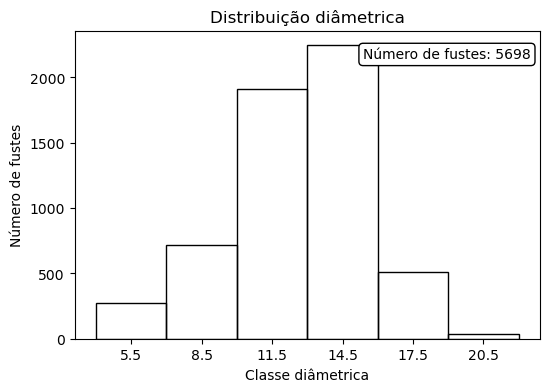

In [ ]:
# gráfico com a distribuição diamêtrica
ACS.distribuicao_diametrica()

In [ ]:
# salvando os resultados do processamento
ACS.salvar_resultados()

Arquivos salvos com sucesso.


### Exemplo de uso - amostragem estratificada

In [ ]:
# leitura dos dados
dados = pd.read_csv('tabela_teste_ae.csv')
dados.head()

,parcela,arvore,Estrato,dap,h,vtcc
0,1,1,3,11.681973,22.1,0.113460
1,1,2,3,13.241691,22.6,0.147592
2,1,3,3,12.414086,22.6,0.130335
3,1,4,3,5.188451,10.0,0.011071
4,1,5,3,14.323945,24.3,0.184130


In [ ]:
# amostragem estratificada
AE = InventarioFlorestal(dados,
                         estrato='Estrato',
                         parcela='parcela',
                         dap='dap',
                         ht='h',
                         volume='vtcc',
                         area_estratos={1: 100.5, 2: 90.5, 3: 40},
                         area_parcela=200,
                         id_arvore='arvore')

# visualizando as informações agregadas por parcela
AE.tabela_parcelas

,estrato,parcela,gi,n_arvores,volume
0,1,30,1.033036,96,9.964447
1,1,35,0.938125,81,9.242964
2,1,37,0.833033,94,7.542007
3,1,38,0.907951,87,8.745429
4,1,41,0.826951,78,7.977891
...,...,...,...,...,...
62,3,27,1.307912,85,13.762863
63,3,34,1.202180,90,12.208175
64,3,55,1.239027,84,12.965696
65,3,57,1.267617,93,12.846757


In [ ]:
# exibindo as estatísticas
AE.resultados

,Parâmetros,Unidade,Resultados
0,Àrea total,hectare,231.0
1,Parcelas alocadas,-,67
2,Parcelas cabíveis,-,11550.0
3,Intensidade amostral,%,0.580087
4,Volume total de madeira,m³,121251.025157
5,Desvio Padrão,m³,0.110637
6,Variância da média,(m³)²,0.01224
7,Erro absoluto,m³,0.220893
8,Erro relativo,%,2.104158
9,IC por parcela,m³,10.50 ± 0.22


In [ ]:
# exibindo as estatísticas dos estratos
AE.resultados_estratos

,Estrato,Área (ha),Volume/parcela (m³),Volume/ha (m³),Volume total (m³)
0,1,100.5,8.76,438.17,44035.92
1,2,90.5,11.17,558.40,50535.34
2,3,40.0,13.34,666.99,26679.77


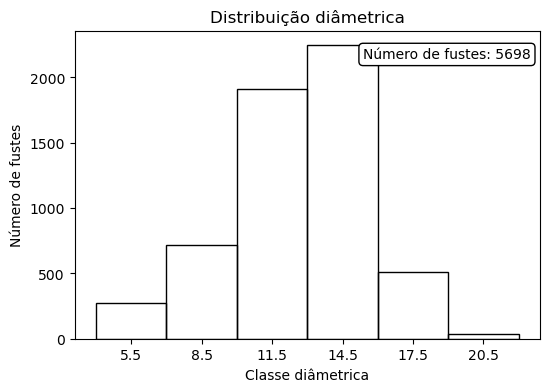

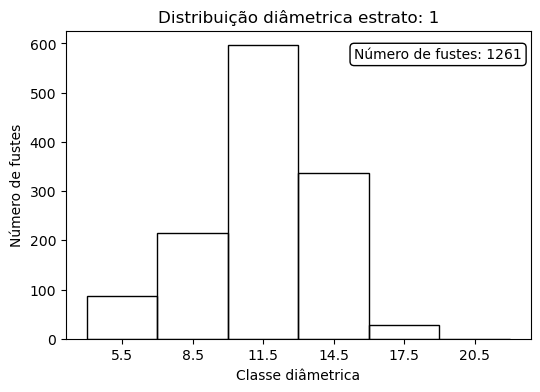

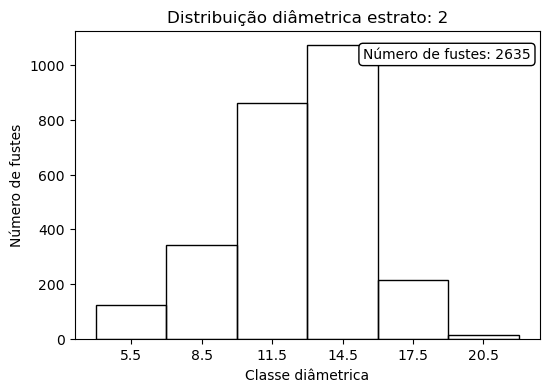

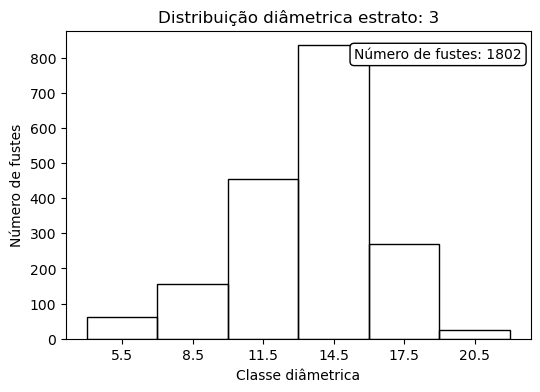

In [ ]:
# gráfico com a distribuição diamêtrica
AE.distribuicao_diametrica()

In [ ]:
# salvando os resultados do processamento
AE.salvar_resultados()

Arquivos salvos com sucesso.
